Analyzing Media Coverage Of Other Countries in Austria
===


The aim of this project is to find out how reporting in Austria's print media about certain countries has changed over time (sentiment, which topics). In two further steps, I would also like to go down to the level of the individual newspapers and their authors and take an explorative look at whether there are tendencies/bias here. As countries of interest I choose Balkan countries because of their proximity to Austria and their long history of conflict.

    Text corpora: Austrian newspaper articles (or their respective twitter posts)
    Language: German
    Time: 2000–2022
    Method: Adding country labels to the articles, Sentiment Scores (, extracting underlying topics of the articles, e.g. with fuzzy topic modeling) 
    
According to https://de.wikipedia.org/wiki/Liste_%C3%B6sterreichischer_Zeitungen_und_Zeitschriften derstandard.at and krone.at reach the most people online, they also cover Austrian society quite well. So, initially, I will focus on these two and might add some more newspapers at a later stage.

* Focus on 2 countries: Serbia and Croatia (like Austria now a EU country)
* I will label an article with "Serbia" if the ratio of amount of words that relate to "Serbia"  compared to words that relate to "Croatia" is greater than 4
* I will also try to find out if there are certain authors who are responsible for a certain tendency.
* Another analysis could be build upon the ratio of "Serbia" and "Albania" or "Kosovo" 

In [1]:
import jupyter_black

jupyter_black.load()

In [178]:
import os
import json
import subprocess
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


data_dir = "data/twitter"

if os.path.exists(data_dir) == False:
    os.makedirs(data_dir)


def dl_user(user, max_results=None, local=False):
    """
    Function to download tweets by username.
    Set local to True, if tweets have already
    been downloaded and are available in data_dir.

    Returns a DataFrame.

    """

    if local == False:
        with open(data_dir + f"/user-{user}.json", "w+") as fo:
            if max_results == None:
                cmd_list = ["snscrape", "--jsonl", "twitter-user", user]
            else:
                cmd_list = [
                    "snscrape",
                    "--jsonl",
                    "-n " + str(max_results),
                    "twitter-user",
                    user,
                ]
            p = subprocess.Popen(cmd_list, stdout=fo)
            p.wait()

    with open(data_dir + f"/user-{user}.json", "r") as fo:
        tweets = fo.readlines()

    tweets = [json.loads(tweets[i]) for i in range(0, len(tweets))]
    print("loaded", len(tweets), "tweets\n")

    df_tweets = pd.DataFrame(tweets)
    df_tweets["date"] = pd.to_datetime(df_tweets["date"])

    return df_tweets

# 1. Scraping newspaper articles

## 1.1. derStandard.at


In [53]:
df_tweets = dl_user("derstandardat", max_results=None, local=True)


df_tweets[["date", "rawContent", "hashtags"]].head()

loaded 272281 tweets



,date,rawContent,hashtags
0,2023-01-25 09:50:19+00:00,Massive Ausfälle bei Microsoft Teams und Outlo...,None
1,2023-01-25 09:50:18+00:00,"ÖSV-Techniktrainer Kroisleitner: ""Potenzial de...",None
2,2023-01-25 09:50:17+00:00,"Leopard-Lieferung: Selenskyj will mehr als ""ze...",None
3,2023-01-25 09:33:54+00:00,"""IBES"" 2023: Jana ist raus – Werden Sie sie ve...",None
4,2023-01-25 09:04:32+00:00,Chanels Haute Couture: Show führte in den Zirk...,None


### Which hashtags are most often used by this user

In [112]:
len_nohashtags = sum(pd.isna(df_tweets.hashtags))
len_nohashtags

260302

In [113]:
hashtags = list(df_tweets.hashtags.dropna())

In [114]:
len(hashtags)

11979

In [115]:
hashtags[623]

['Bundespressedienst']

In [119]:
hashtags_flat = [item for sublist in hashtags for item in sublist]

len(hashtags_flat)

15147

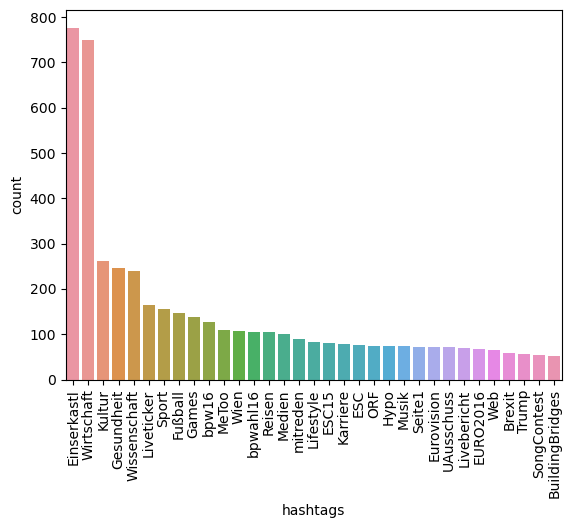

In [180]:
df_hashtags = pd.concat(
    [
        pd.DataFrame(hashtags_flat, columns=["hashtags"]),
        df_tweets.loc[pd.isna(df_tweets.hashtags), ["hashtags"]],
    ],
    sort=False,
).astype(str)

df_hashtags["count"] = 1
df_hashtags = (
    df_hashtags.groupby(["hashtags"])
    .count()
    .sort_values("count", ascending=False)
    .reset_index()
)

# all the ones tha occur only few times and label them as "other" and group again
df_hashtags.loc[df_hashtags["count"] <= 50, "hashtags"] = "other"
df_hashtags = (
    df_hashtags.groupby(["hashtags"])
    .sum()
    .sort_values("count", ascending=False)
    .reset_index()
)

# drop the first 2 most frequently hashtags (None, other)
sns.barplot(x="hashtags", y="count", data=df_hashtags.drop(0, axis=0).drop(1, axis=0))
plt.xticks(rotation=90);

### Which countries are the tweets referring to?

words to filter for:
- serbien  
- serbe
- serbin
- serben
- serbisch
- serbo

In [203]:
df_serbien = (
    df_tweets.copy()
    .loc[
        df_tweets.renderedContent.str.lower().str.contains("serbien")
        | df_tweets.renderedContent.str.lower().str.contains("serbe")  # incl. serben
        | df_tweets.renderedContent.str.lower().str.contains("serbin")
        | df_tweets.renderedContent.str.lower().str.contains("serbisch")
        | df_tweets.renderedContent.str.lower().str.contains("serbo"),
        ["date", "renderedContent", "hashtags"],
    ]
    .reset_index(drop=True)
)

df_serbien.head()

,date,renderedContent,hashtags
0,2023-01-23 21:45:59+00:00,"Serbiens Präsident Vučić in Kosovo-Frage für ""...",None
1,2023-01-07 16:13:24+00:00,"Spannungen im Nordkosovo: ""Serbien muss nun vo...",None
2,2023-01-06 20:24:57+00:00,Soldat im Kosovo verwundet Serben – Sorgen vor...,None
3,2022-12-29 16:58:50+00:00,Konflikt zwischen Kosovo und Serbien: Schlecht...,None
4,2022-12-28 17:12:47+00:00,"Karl Schwarzenberg: ""Österreich muss eine klar...",None


words to filter for:
- kroatien
- kroate
- kroatin
- kroaten
- kroatisch
- kroato

In [202]:
df_kroatien = (
    df_tweets.copy()
    .loc[
        df_tweets.renderedContent.str.lower().str.contains("kroatien")
        | df_tweets.renderedContent.str.lower().str.contains("kroate")  # incl. serben
        | df_tweets.renderedContent.str.lower().str.contains("kroatin")
        | df_tweets.renderedContent.str.lower().str.contains("kroatisch")
        | df_tweets.renderedContent.str.lower().str.contains("kroato"),
        ["date", "renderedContent", "hashtags"],
    ]
    .reset_index(drop=True)
)

df_kroatien.head()

,date,renderedContent,hashtags
0,2023-01-23 09:54:51+00:00,Thiem gibt vor Davis-Cup-Duell mit Kroatien En...,None
1,2023-01-06 11:28:36+00:00,Österreich in Bestbesetzung ins Davis-Cup-Duel...,None
2,2023-01-04 05:14:58+00:00,Großer Ansturm? Was der Schengen-Beitritt Kroa...,None
3,2023-01-03 13:32:51+00:00,Kritik in Kroatien über Preiserhöhungen infolg...,None
4,2023-01-01 06:54:57+00:00,Kroatien führt den Euro ein und wird Schengenl...,None
